In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
#Loading training set into dataframe
df = pd.read_excel('./data/gang_toc_train.xlsx')
df.head()

,井名,Depth,GR,AC,CNL,DEN,RT,RXO,TOC
0,龙会4,4384.250,59.898,51.739,2.986,2.730,NaN,NaN,0.095
1,龙会4,4379.500,60.681,51.564,2.656,2.723,NaN,NaN,0.143
2,龙会4,4386.875,124.560,53.859,3.956,2.625,NaN,NaN,0.143
3,峰探1,4584.500,40.030,50.546,6.603,2.654,1109.175,951.854,0.150
4,龙会4,4378.125,63.343,57.818,4.362,2.694,NaN,NaN,0.190


In [4]:
df = df.drop(columns='井名')
df = df.drop(columns='Depth')

In [5]:
#This is an example, taking TOC as label to predict
label = df['TOC']
train = df.drop('TOC', axis=1) # we don't need it in this project
label.shape, train.shape

((236,), (236, 6))

In [7]:
#Function to min-max normalize
def normalize(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode
    @return a DataFrame with normalized specified features
    """
    result = df.copy() # do not touch the original df
    for feature_name in cols:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        if max_value > min_value:
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [5]:
#Normalizing dataset
new_df = normalize(df,df.columns)
new_df

,GR,AC,CNL,DEN,RT,RXO,TOC
0,0.153128,0.100947,0.116017,0.917275,NaN,NaN,0.000000
1,0.155955,0.096731,0.103722,0.900243,NaN,NaN,0.008980
2,0.386578,0.152010,0.152155,0.661800,NaN,NaN,0.008980
3,0.081398,0.072211,0.250773,0.732360,0.101778,0.079420,0.010290
4,0.165566,0.247369,0.167281,0.829684,NaN,NaN,0.017774
...,...,...,...,...,...,...,...
231,0.496177,0.523111,0.401997,0.347932,0.002923,0.002404,0.970065
232,0.437357,0.616687,0.670057,0.333333,NaN,NaN,0.971936
233,0.344395,0.744033,0.767594,0.119221,0.000899,0.000494,0.975678
234,0.216550,0.104873,0.187847,0.822384,0.005154,0.005038,0.975678


In [6]:
#This is an example, taking TOC as label to predict
label = new_df['TOC']
train = new_df.drop('TOC', axis=1) # we don't need it in this project
label.shape, train.shape

((236,), (236, 6))

In [7]:
label.isnull().values.any()
train.isnull().values.any()

True

In [8]:
#Test Nan and fill with mean
for column in list(train.columns[train.isnull().sum() > 0]):
    mean_val = train[column].mean()
    train[column].fillna(mean_val, inplace=True)

In [9]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=6,shuffle=True,random_state=42)
kfold.get_n_splits(train)

6

In [10]:
train = np.array(train)
label = np.array(label)

In [11]:
train = torch.tensor(train, dtype=torch.float32)
label = torch.tensor(label, dtype=torch.float32)

In [12]:
label.shape, train.shape

(torch.Size([236]), torch.Size([236, 6]))

In [13]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [20]:
class PasseyNet_mlp(nn.Module):
    def __init__(self, input_size):
        super(PasseyNet_mlp, self).__init__()
        self.fc0 = nn.Linear(6, 236)  # 236X236
        self.fc1 = nn.Linear(236, 64)  # 2X64
        self.fc2 = nn.Linear(64, 6)  # 282X4
        self.fc3 = nn.Linear(6, 1)  # 282X1
        
    def forward(self, x):
        well_log_matrix = F.relu(self.fc0(x))
        well_log_matrix = F.relu(self.fc1(well_log_matrix))
        well_log_matrix = F.relu(self.fc2(well_log_matrix))
        
        RO_matrix = F.relu(self.fc0(x))
        RO_matrix = F.relu(self.fc1(RO_matrix))
        RO_matrix = F.relu(self.fc2(RO_matrix))
        RO_matrix = F.relu(self.fc3(RO_matrix))
        
        Bias_matrix = F.relu(self.fc0(x))
        Bias_matrix = F.relu(self.fc1(Bias_matrix))
        Bias_matrix = F.relu(self.fc2(Bias_matrix))
        Bias_matrix = F.relu(self.fc3(Bias_matrix))
        
        output = torch.matmul(torch.matmul(x, well_log_matrix.T),torch.pow(10.0,RO_matrix))+Bias_matrix
        
        return output  

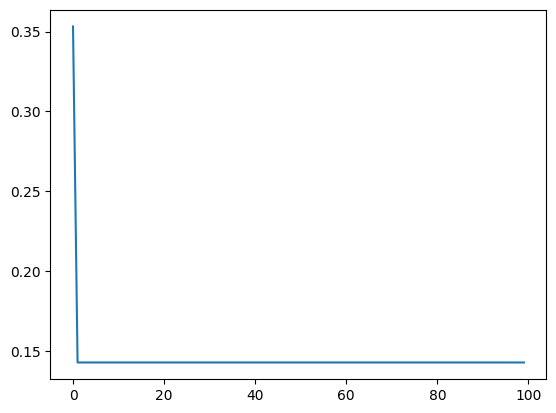

In [22]:
model = PasseyNet_mlp(input_size=236)  # 输入大小为236
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()
loss_list = []

for epoch in range(100):  
    output = model(train)
    y_pred = []
    for i in range(len(output)):
        y_pred.append(output[i])  
    y_pred = torch.stack(y_pred).view(236)
    loss = criterion(y_pred, label)
    loss_list.append(loss.item())
    
    optimizer.zero_grad()   
    loss.backward()           
    optimizer.step()

plt.plot(loss_list) 
plt.show()

In [23]:
y_pred_df=

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 